In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3

In [3]:
conn = sqlite3.connect('your_database.db')

In [4]:
cursor = conn.cursor()

In [7]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

In [8]:
customers.to_sql('customers', conn, index = False, if_exists = 'replace')
geolocation.to_sql('geolocation', conn, index = False, if_exists = 'replace')
items.to_sql('items', conn, index = False, if_exists = 'replace')
payments.to_sql('payments', conn, index = False, if_exists = 'replace')
reviews.to_sql('reviews', conn, index = False, if_exists = 'replace')
products.to_sql('products', conn, index = False, if_exists = 'replace')
translation.to_sql('translation', conn, index = False, if_exists = 'replace')
sellers.to_sql('sellers', conn, index = False, if_exists = 'replace')
orders.to_sql('orders', conn, index = False, if_exists = 'replace')

99441

In [4]:
#reviews -> review_creation_date, review_answer_timestamp
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])
#orders -> order_purchase_timestamp, order_approved_at, 
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

### 1. 제품 카테고리

- 매출을 기준으로 상위 10개 제품 카테고리 추출
- 주문상태가 canceled, unavailable -> x

In [136]:
query2 = """
               select product_category_name_english as category,
               count(distinct order_id) as order_count,
               sum(payment_value) as revenue
               from(SELECT *
               FROM   products AS a
               LEFT
               JOIN   translation AS b
               ON     a.product_category_name = b.product_category_name
               LEFT
               JOIN   items AS c
               ON     a.product_id = c.product_id
               LEFT
               JOIN   orders AS d
               ON     c.order_id = d.order_id
               LEFT
               JOIN   payments AS e
               ON     c.order_id = e.order_id
                ) as p
                where category is not null
                group by category 
                order by revenue desc
                limit 10 
        
        
        """

In [137]:
pd.read_sql_query(query2, conn)

,category,order_count,revenue
0,bed_bath_table,9417,1712553.67
1,health_beauty,8836,1657373.12
2,computers_accessories,6689,1585330.45
3,furniture_decor,6449,1430176.39
4,watches_gifts,5624,1429216.68
5,sports_leisure,7720,1392127.56
6,housewares,5884,1094758.13
7,auto,3897,852294.33
8,garden_tools,3518,838280.75
9,cool_stuff,3632,779698.00


- Top5 카테고리
    - bed_bath_table
    - health_beauty
    - computers_accessories
    - furniture_decor
    - watches_gifts


- 데이터마트 생성
    - 첫 구매 일자
    - 최근 구매 일자
    - 단일 고객 별 주문 수
    - 고객의 재구매 여부 
    - interval_purchase
    - cycle_purchase

order_purchase_timestamp 이 생길 때마다 customer_id도 생기기에 이 둘의 수는 똑같다.  -> 99441
고객의 재구매를 확인하기 위해서는 customer_unique_id를 확인해야 한다. 

In [9]:
query3 = """

select *, customer_unique_id, 
case when order_count >= 2 then 'Y' else 'N' end as repurchase
from(select customer_unique_id, count(distinct order_id) as order_count,
    MIN(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS first_pur,
    MAX(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS recent_pur
    from(select customer_unique_id, A.order_id, order_purchase_timestamp, C.product_id
        from orders A
        left join customers B
        on A.customer_id = B.customer_id
        left join items C
        on A.order_id = C.order_id
        ) G
    left join 
    (select product_id, product_category_name_english as cat
    
    from products as D
    left join translation E 
    on D.product_category_name = E.product_category_name) F
    
    on G.product_id = F.product_id
    where cat = 'bed_bath_table'
    group by customer_unique_id )
"""

In [11]:
repur_bed_bath_tab = pd.read_sql_query(query3, conn)

In [18]:
repur_bed_bath_tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9145 entries, 0 to 9144
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_unique_id  9145 non-null   object
 1   order_count         9145 non-null   int64 
 2   first_pur           9145 non-null   object
 3   recent_pur          9145 non-null   object
 4   customer_unique_id  9145 non-null   object
 5   repurchase          9145 non-null   object
dtypes: int64(1), object(5)
memory usage: 428.8+ KB


In [15]:
#bed_bath_tab 카테고리의 재구매율 
repur_bed_bath_tab.loc[(repur_bed_bath_tab.repurchase == 'Y') & (repur_bed_bath_tab.count_order >= 2)]

,customer_unique_id,order_count,first_pur,recent_pur,customer_unique_id,repurchase
55,0178b244a5c281fb2ade54038dd4b161,2,2017-05-10,2018-07-28,0178b244a5c281fb2ade54038dd4b161,Y
92,02e9109b7e0a985108b43e573b6afb23,2,2018-05-13,2018-05-14,02e9109b7e0a985108b43e573b6afb23,Y
106,0333b2fc6ba7014702e08ef613850270,2,2017-08-24,2017-11-06,0333b2fc6ba7014702e08ef613850270,Y
117,0396c443fdda5498c7e9ed5b34871c5a,2,2017-05-05,2017-05-05,0396c443fdda5498c7e9ed5b34871c5a,Y
138,043aee247e71edff7045664609f4d806,2,2017-03-22,2017-07-17,043aee247e71edff7045664609f4d806,Y
...,...,...,...,...,...,...
9062,fd8ccc89be43894d2553494c71a61fd8,2,2018-03-13,2018-04-19,fd8ccc89be43894d2553494c71a61fd8,Y
9065,fdb2f8a871f180fefdf3ba06bf7ab179,2,2017-06-06,2017-06-06,fdb2f8a871f180fefdf3ba06bf7ab179,Y
9080,fe28d443ab89dc67f5858bc2beda299a,2,2017-07-18,2017-07-18,fe28d443ab89dc67f5858bc2beda299a,Y
9088,fe52c2abb172426dd6416cc69e6b3689,2,2017-09-16,2017-09-23,fe52c2abb172426dd6416cc69e6b3689,Y


In [20]:
round(repur_bed_bath_tab['repurchase'].value_counts(normalize=True) *100, 2)

repurchase
N    97.24
Y     2.76
Name: proportion, dtype: float64

In [385]:
labels = ['N', 'Y']
values = [97.24, 2.76]

Text(0.5, 1.0, 'bed_bath_tab Repurchase Proportion')

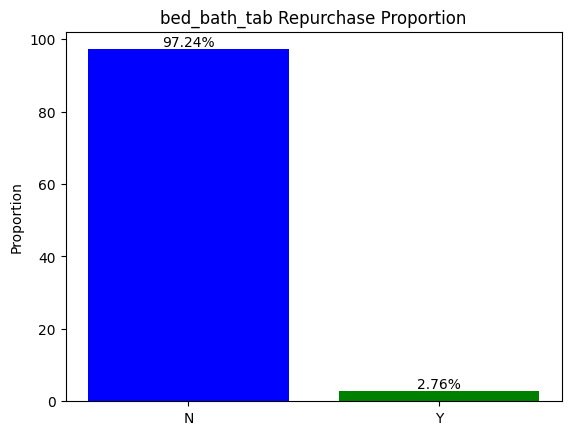

In [388]:
fig, ax = plt.subplots()
ax.bar(labels, values, color=['blue', 'green'])

# 퍼센트 텍스트 추가
for i, v in enumerate(values):
    ax.text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom')

# 그래프 설정
ax.set_ylabel('Proportion')
ax.set_title('bed_bath_tab Repurchase Proportion')

In [21]:
query4 = """

select *, customer_unique_id, 
case when order_count >= 2 then 'Y' else 'N' end as repurchase
from(select customer_unique_id, count(distinct order_id) as order_count,
    MIN(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS first_pur,
    MAX(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS recent_pur
    from(select customer_unique_id, A.order_id, order_purchase_timestamp, C.product_id
        from orders A
        left join customers B
        on A.customer_id = B.customer_id
        left join items C
        on A.order_id = C.order_id
        ) G
    left join 
    (select product_id, product_category_name_english as cat
    
    from products as D
    left join translation E 
    on D.product_category_name = E.product_category_name) F
    
    on G.product_id = F.product_id
    where cat = 'health_beauty'
    group by customer_unique_id )
"""

In [22]:
repur_health_beauty = pd.read_sql_query(query4, conn)

In [23]:
filter_condition = lambda df: (df['repurchase'] == 'Y') & (df['order_count'] >= 2)

In [24]:
repur_health_beauty[filter_condition(repur_health_beauty)]

,customer_unique_id,order_count,first_pur,recent_pur,customer_unique_id,repurchase
47,01886ef98f995e4f2dd75a1d04c97397,2,2017-11-27,2018-03-09,01886ef98f995e4f2dd75a1d04c97397,Y
167,04d3c2795b83634312bf3f86f41f7901,2,2017-06-09,2017-08-08,04d3c2795b83634312bf3f86f41f7901,Y
292,08c07c761592a71b85136aa4fe76a6f4,2,2017-08-11,2018-01-26,08c07c761592a71b85136aa4fe76a6f4,Y
303,08fb46d35bb3ab4037202c23592d1259,2,2018-06-03,2018-06-04,08fb46d35bb3ab4037202c23592d1259,Y
319,0981a271500799427cdf345e9121e20b,2,2017-04-03,2017-04-17,0981a271500799427cdf345e9121e20b,Y
...,...,...,...,...,...,...
8450,fa0cf5b25732a933725b83d2f716000a,2,2017-09-13,2017-09-13,fa0cf5b25732a933725b83d2f716000a,Y
8494,fb5e89c121d9569d1a58e0afb54da971,2,2017-09-12,2017-09-12,fb5e89c121d9569d1a58e0afb54da971,Y
8509,fbacf55907cfeeab0f1cb05ac31c429e,2,2018-01-27,2018-01-27,fbacf55907cfeeab0f1cb05ac31c429e,Y
8576,fda3a3eb3370c1295a4fc3f6cd3d7604,2,2017-09-04,2017-09-04,fda3a3eb3370c1295a4fc3f6cd3d7604,Y


In [25]:
#health_beauty의 재구매율
round(repur_health_beauty['repurchase'].value_counts(normalize=True) *100, 2)

repurchase
N    98.26
Y     1.74
Name: proportion, dtype: float64

In [389]:
labels =['N','Y']
values = [98.26, 1.74]

Text(0.5, 1.0, 'health_beauty Repurchase Proportion')

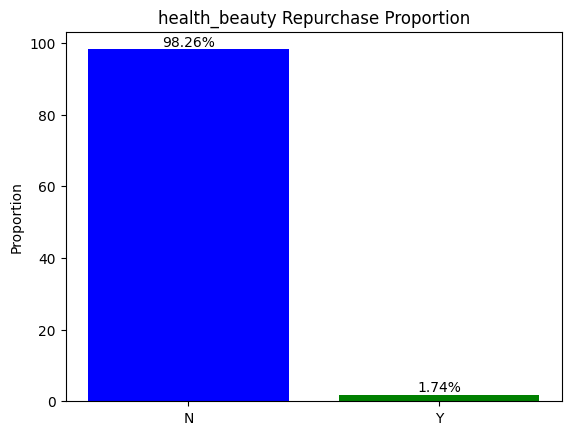

In [391]:
fig, ax = plt.subplots()
ax.bar(labels, values, color=['blue', 'green'])

# 퍼센트 텍스트 추가
for i, v in enumerate(values):
    ax.text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom')

# 그래프 설정
ax.set_ylabel('Proportion')
ax.set_title('health_beauty Repurchase Proportion')

In [26]:
query5 = """

select *, customer_unique_id, 
case when order_count >= 2 then 'Y' else 'N' end as repurchase
from(select customer_unique_id, count(distinct order_id) as order_count,
    MIN(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS first_pur,
    MAX(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS recent_pur
    from(select customer_unique_id, A.order_id, order_purchase_timestamp, C.product_id
        from orders A
        left join customers B
        on A.customer_id = B.customer_id
        left join items C
        on A.order_id = C.order_id
        ) G
    left join 
    (select product_id, product_category_name_english as cat
    
    from products as D
    left join translation E 
    on D.product_category_name = E.product_category_name) F
    
    on G.product_id = F.product_id
    where cat = 'computers_accessories'
    group by customer_unique_id )
"""

In [27]:
repur_computers_accessories = pd.read_sql_query(query5, conn)

In [28]:
repur_computers_accessories[filter_condition(repur_computers_accessories)]

,customer_unique_id,order_count,first_pur,recent_pur,customer_unique_id,repurchase
68,02b20b7c813efede140142ac610e36dc,2,2018-03-19,2018-03-19,02b20b7c813efede140142ac610e36dc,Y
76,02fbe4db886eb98774c8ba300d39fa79,2,2018-02-17,2018-02-17,02fbe4db886eb98774c8ba300d39fa79,Y
145,0621c2a5979d3e887ae519620cbe2926,2,2017-06-09,2017-08-10,0621c2a5979d3e887ae519620cbe2926,Y
172,07342638d0e0aad32c3cf0efc1a37ba5,2,2017-08-18,2017-09-27,07342638d0e0aad32c3cf0efc1a37ba5,Y
237,09d74edf20acb4f9523fb1cf19a18456,2,2017-11-16,2018-03-05,09d74edf20acb4f9523fb1cf19a18456,Y
...,...,...,...,...,...,...
6244,f30856ad31d3e74253a3f4ccef670648,2,2018-02-02,2018-02-02,f30856ad31d3e74253a3f4ccef670648,Y
6280,f46ebdbd5c48c0683980a759b8937912,2,2018-02-20,2018-02-20,f46ebdbd5c48c0683980a759b8937912,Y
6326,f64075e7fa628bdc6c3e7c3108d7c624,2,2018-01-30,2018-01-30,f64075e7fa628bdc6c3e7c3108d7c624,Y
6401,f95de29d9e810e69f55626ff1bbd4d60,2,2017-12-21,2018-01-06,f95de29d9e810e69f55626ff1bbd4d60,Y


In [30]:
#computers_accessories의 재구매율
round(repur_computers_accessories['repurchase'].value_counts(normalize=True)* 100, 2)

repurchase
N    98.08
Y     1.92
Name: proportion, dtype: float64

In [392]:
labels = ['N', 'Y']
values = [98.08, 1.92]

Text(0.5, 1.0, 'computers_accessories Repurchase Proportion')

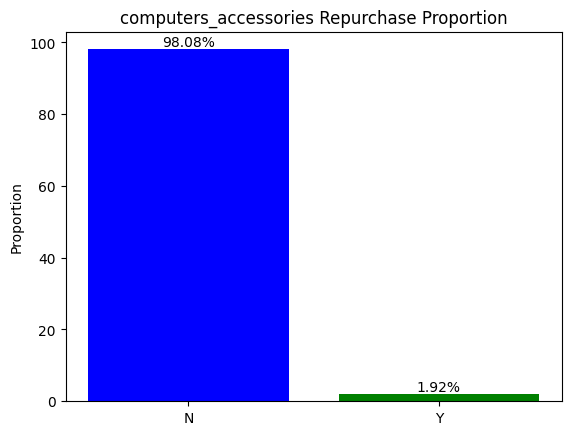

In [394]:
fig, ax = plt.subplots()
ax.bar(labels, values, color=['blue', 'green'])

# 퍼센트 텍스트 추가
for i, v in enumerate(values):
    ax.text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom')

# 그래프 설정
ax.set_ylabel('Proportion')
ax.set_title('computers_accessories Repurchase Proportion')

### 2. 월별 고객 주문 수

- 가장 매출이 높은 top5 카테고리 모두 재구매율이 3% 미만으로 매우 낮기에 카테고리로 하는 코호트 분석으로 유의미한 결론을 도출하기 적합하지 않다고 판단
- 따라서 월별로 특정 시기 유입된(주문한)고객을 코호트로 설정하여 분석

- 고객 주문수 
    - 주문의 기준은 'order_purchase_timestamp'
    - 고객의 기준은 'customer_unique_id' 로 파악 


In [38]:
#연도/월 별 주문량 확인 
query6 = """SELECT  STRFTIME('%Y-%m', order_purchase_timestamp) AS period,
                COUNT(distinct customer_id) AS purchase_count
          FROM  orders 
         WHERE  order_status != 'unavailable'
           AND  order_status != 'canceled'
         GROUP BY  period
         ORDER BY  period        
        """
period = pd.read_sql_query(query6, conn)




In [39]:
period

,period,purchase_count
0,2016-09,2
1,2016-10,293
2,2016-12,1
3,2017-01,787
4,2017-02,1718
5,2017-03,2617
6,2017-04,2377
7,2017-05,3640
8,2017-06,3205
9,2017-07,3946


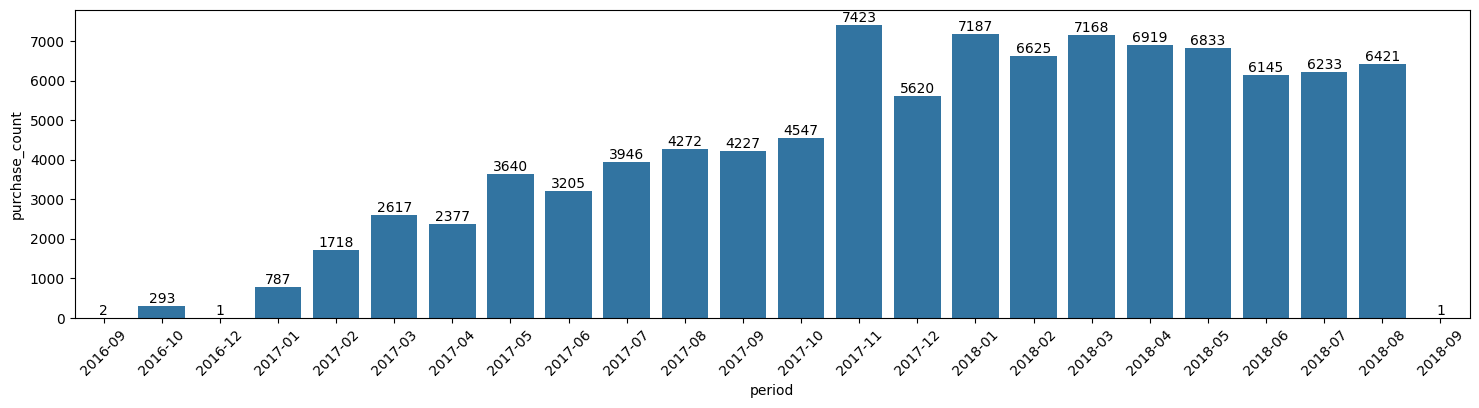

In [40]:
fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
sns.barplot(data = period, x = 'period', y = 'purchase_count')
plt.xticks(rotation = 45)
ax3.bar_label(ax3.containers[0])
plt.show()

- 연도/월 별
    - 16년은 9월-12월까지의 데이터밖에 없으며, 많은 데이터가 적재되지 x
    - 제대로된 경향을 파악할 없는, 데이터 규모가 작은 연도/월은 제외 ->17년 8월 부터 18년 8월까지 1년치에 대한 주문 건수 추출하는 것이 좋을 것 같다. 
    - 2017-11월의 주문 건수가 급증했으며 2017-12월에 다시 급감하는 모습을 보인다. -> 블랙 프라이데이 세일로 추정된다 
    - 11월, 12월의 일별 주문 건수 추이를 파악해본다
    - 리텐션 분석을 위해 11월 1일부터 주차별 코호트 분석 -> 12월까지 리텐션을 유지하기 위한 전략

In [149]:
query7 = """SELECT  STRFTIME('%d', order_purchase_timestamp) AS period,
                COUNT(distinct customer_id) AS purchase_count
          FROM  orders 
         WHERE  order_status != 'unavailable'
           AND  order_status != 'canceled'
           AND STRFTIME('%Y', order_purchase_timestamp) = '2017'
           AND STRFTIME('%m', order_purchase_timestamp) = '11'
         GROUP BY  period
         ORDER BY  period        
        """
NOV_period = pd.read_sql_query(query7, conn)

In [150]:
average_purchase_count = NOV_period['purchase_count'].mean()

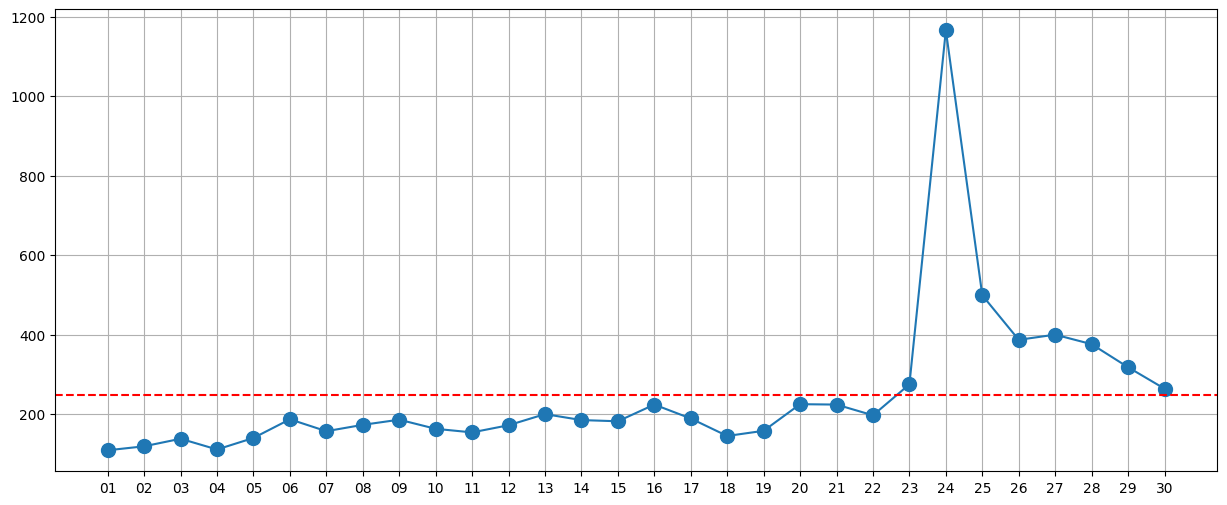

In [152]:
#11월 주문 건수 추이
plt.figure(figsize=(15, 6))
plt.plot(NOV_period['period'], NOV_period['purchase_count'], marker = 'o', markersize = 10)
plt.axhline(y=average_purchase_count, color='r', linestyle='--', label='Average Purchase Count')

plt.grid(True)
plt.show()


In [140]:
query8 = """SELECT  STRFTIME('%d', order_purchase_timestamp) AS period,
                COUNT(distinct customer_id) AS purchase_count
          FROM  orders 
         WHERE  order_status != 'unavailable'
           AND  order_status != 'canceled'
           AND STRFTIME('%Y', order_purchase_timestamp) = '2017'
           AND STRFTIME('%m', order_purchase_timestamp) = '12'
         GROUP BY  period
         ORDER BY  period        
        """
DEC_period = pd.read_sql_query(query8, conn)

In [141]:
average_purchase_count = DEC_period['purchase_count'].mean()

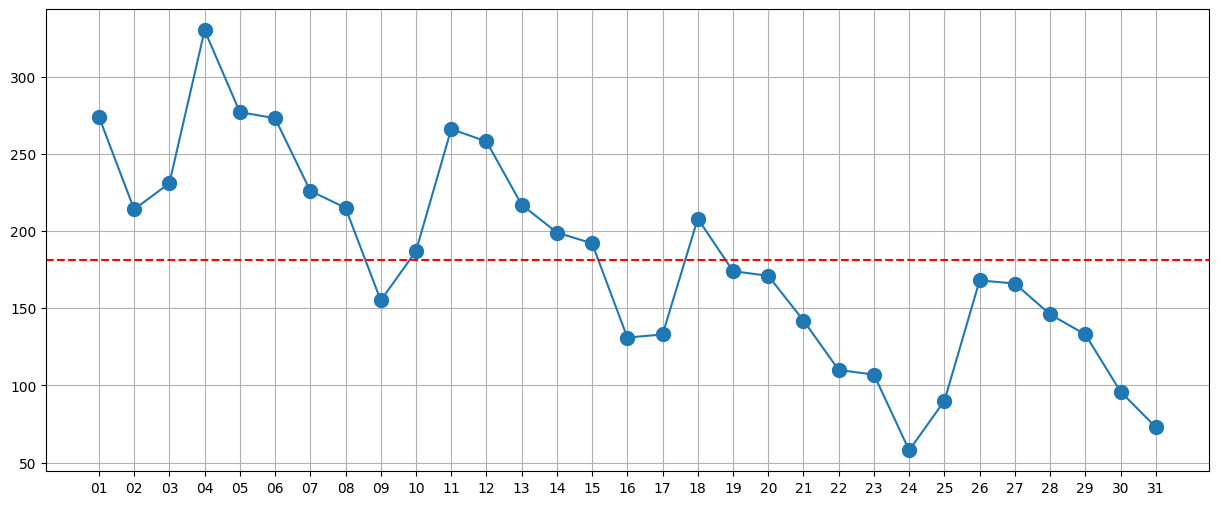

In [143]:
#12월 주문 건수 추이
plt.figure(figsize=(15, 6))
plt.plot(DEC_period['period'], DEC_period['purchase_count'], marker = 'o', markersize = 10)
plt.axhline(y=average_purchase_count, color='r', linestyle='--', label='Average Purchase Count')

plt.grid(True)
plt.show()

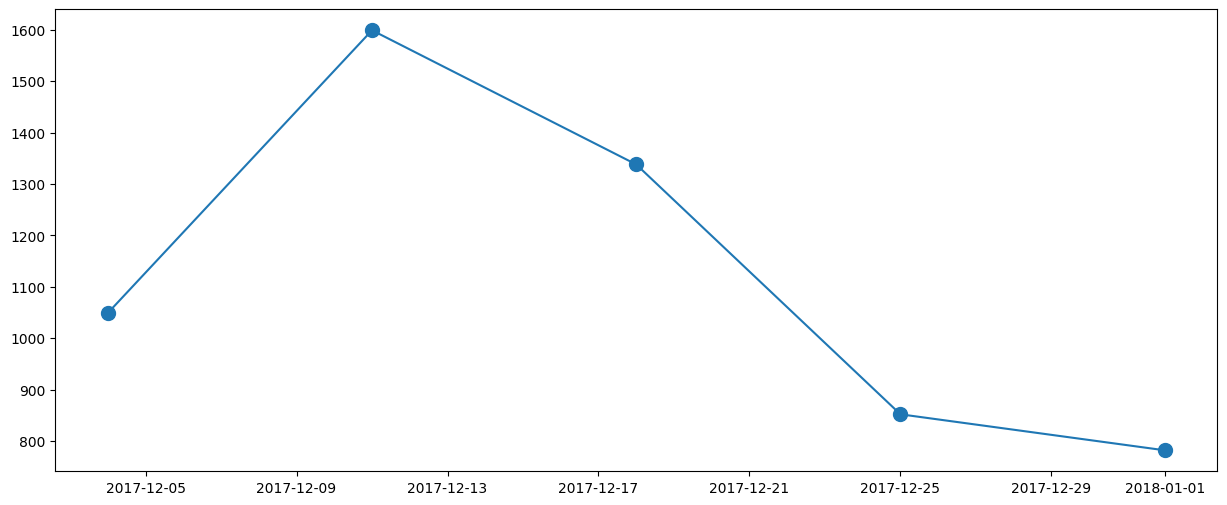

In [101]:
#WEEKLY 
DEC_period['period'] = pd.to_datetime(DEC_period['period'])
DEC_period.set_index(['period'], inplace=True)
weekly_DEC_period = DEC_period.resample('W-Mon').sum()
plt.figure(figsize=(15, 6))
plt.plot(weekly_DEC_period['period'], weekly_DEC_period['purchase_count'], marker='o', markersize=10, label='Weekly Purchase Count')

In [131]:
query9 = """SELECT  STRFTIME('%Y-%m-%d', order_purchase_timestamp) AS period,
                COUNT(distinct customer_id) AS purchase_count
          FROM  orders 
         WHERE  order_status != 'unavailable'
           AND  order_status != 'canceled'
           AND STRFTIME('%Y', order_purchase_timestamp) = '2018'
           AND STRFTIME('%m', order_purchase_timestamp) = '01'
         GROUP BY  period
         ORDER BY  period        
        """
JAN_period = pd.read_sql_query(query9, conn)

In [132]:
JAN_period['period'] = pd.to_datetime(JAN_period['period'])

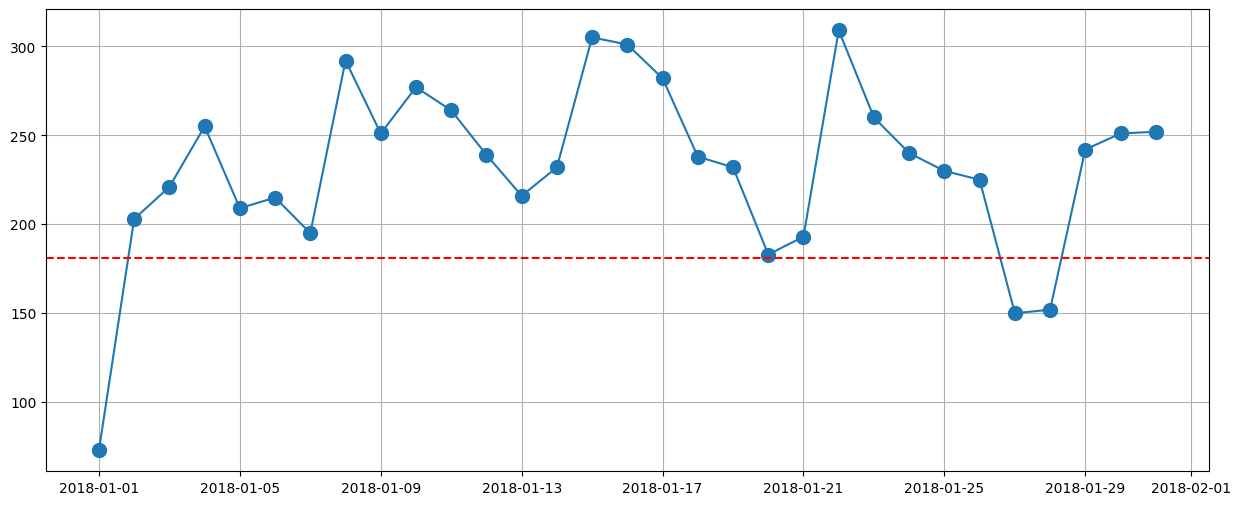

In [144]:
#1월 주문 건수 추이
plt.figure(figsize=(15, 6))
plt.plot(JAN_period['period'], JAN_period['purchase_count'], marker = 'o', markersize = 10)
plt.axhline(y=average_purchase_count, color='r', linestyle='--', label='Average Purchase Count')

plt.grid(True)
plt.show()

In [184]:
#2주간격으로 11월~1월까지의 주문 추이  
query10 = """SELECT  STRFTIME('%Y-%m-%d', order_purchase_timestamp) AS period,
                COUNT(distinct customer_id) AS purchase_count
          FROM  orders 
         WHERE  order_status != 'unavailable'
           AND  order_status != 'canceled'
           AND STRFTIME('%Y-%m', order_purchase_timestamp) in ('2018-01', '2017-11','2017-12')
         GROUP BY  period
         ORDER BY  period
         """
total_period = pd.read_sql_query(query10, conn)

In [188]:
total_period['period'] = pd.to_datetime(total_period['period'])

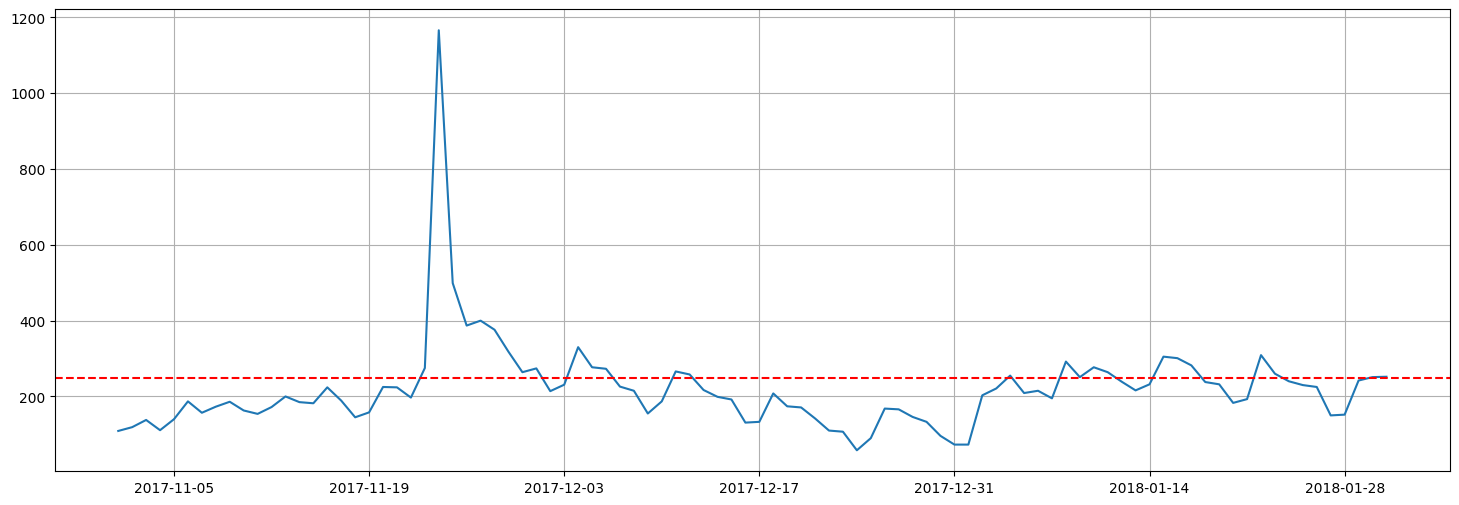

In [189]:
#Xticks
plt.figure(figsize=(18, 6))
plt.plot(total_period['period'], total_period['purchase_count'])
plt.axhline(y=average_purchase_count, color='r', linestyle='--', label='Average Purchase Count')
plt.xticks(pd.date_range(start=total_period['period'].min(), end=total_period['period'].max(), freq='2W-SUN'))

plt.grid(True)
plt.show()

2017-11월부터 2018-1월까지의 주문 수 추이를 확인해보면 11월 24일이 월등히 높고, 그 이후로 급감하며, 12월 말부터는 평균 이하의 주문 수를 보인다. 
2018년 1월 초에 평균-평균이상의 주문수를 보이고, 그 이후에는 상승 및 하락을 반복한다. 

### 3-1. retention을 구하기 전에 반복 구매를 한 고객은 몇 명이며, 전체 매출에서 차지하는 비중은 얼마나 되는지 확인

### 3-2. 최초로 상품을 구매한 월을 코호트로 설정한 월별 retention 

- range retention
- 구매 주기 : 1달 설정 
- 코호트 : 상품 구매 


In [278]:

query = """
        WITH    cohort AS (
        SELECT  b.customer_unique_id,
                MIN(STRFTIME('%Y-%m-01', order_purchase_timestamp)) AS cohort_date
        FROM    orders AS a
        LEFT 
        JOIN    customers AS b
        ON      a.customer_id = b.customer_id
        GROUP
        BY      b.customer_unique_id
        
                ), 
                
                cohort_size AS(
        SELECT  cohort_date,
                COUNT(DISTINCT customer_unique_id) AS  cohort_cnt
        FROM    cohort
        GROUP
        BY      cohort_date
        
                ), 
                
                activities AS (
        SELECT  b.customer_unique_id,
                STRFTIME('%Y-%m-01', order_purchase_timestamp) AS activity_date
        FROM    orders AS a
        LEFT 
        JOIN    customers AS b
        ON      a.customer_id = b.customer_id 
                )
        
        
        SELECT  cohort.cohort_date,
                CAST((JULIANDAY(activity_date) - JULIANDAY(cohort.cohort_date))/30 AS int) AS month_gap,
                cohort_cnt,
                COUNT(DISTINCT activities.customer_unique_id) AS activitiy_cnt,
                ROUND(COUNT(DISTINCT activities.customer_unique_id)*100.0 / cohort_cnt, 2) AS retention_rate
        FROM    cohort
        LEFT
        JOIN    cohort_size
        ON      cohort.cohort_date = cohort_size.cohort_date
        LEFT
        JOIN    activities
        ON      cohort.customer_unique_id = activities.customer_unique_id
        GROUP
        BY      1, 2, 3
        """

cohort = pd.read_sql_query(query,conn)
cohort

,cohort_date,month_gap,cohort_cnt,activitiy_cnt,retention_rate
0,2016-09-01,0,4,4,100.00
1,2016-10-01,0,321,321,100.00
2,2016-10-01,6,321,1,0.31
3,2016-10-01,9,321,1,0.31
4,2016-10-01,11,321,1,0.31
...,...,...,...,...,...
216,2018-08-01,0,6271,6271,100.00
217,2018-08-01,1,6271,7,0.11
218,2018-08-01,2,6271,2,0.03
219,2018-09-01,0,5,5,100.00


In [279]:
new_df = cohort.pivot_table(index = 'cohort_date',
                   columns = 'month_gap',
                   values = 'retention_rate',
                   fill_value = 0)

<AxesSubplot: xlabel='month_gap', ylabel='cohort_date'>

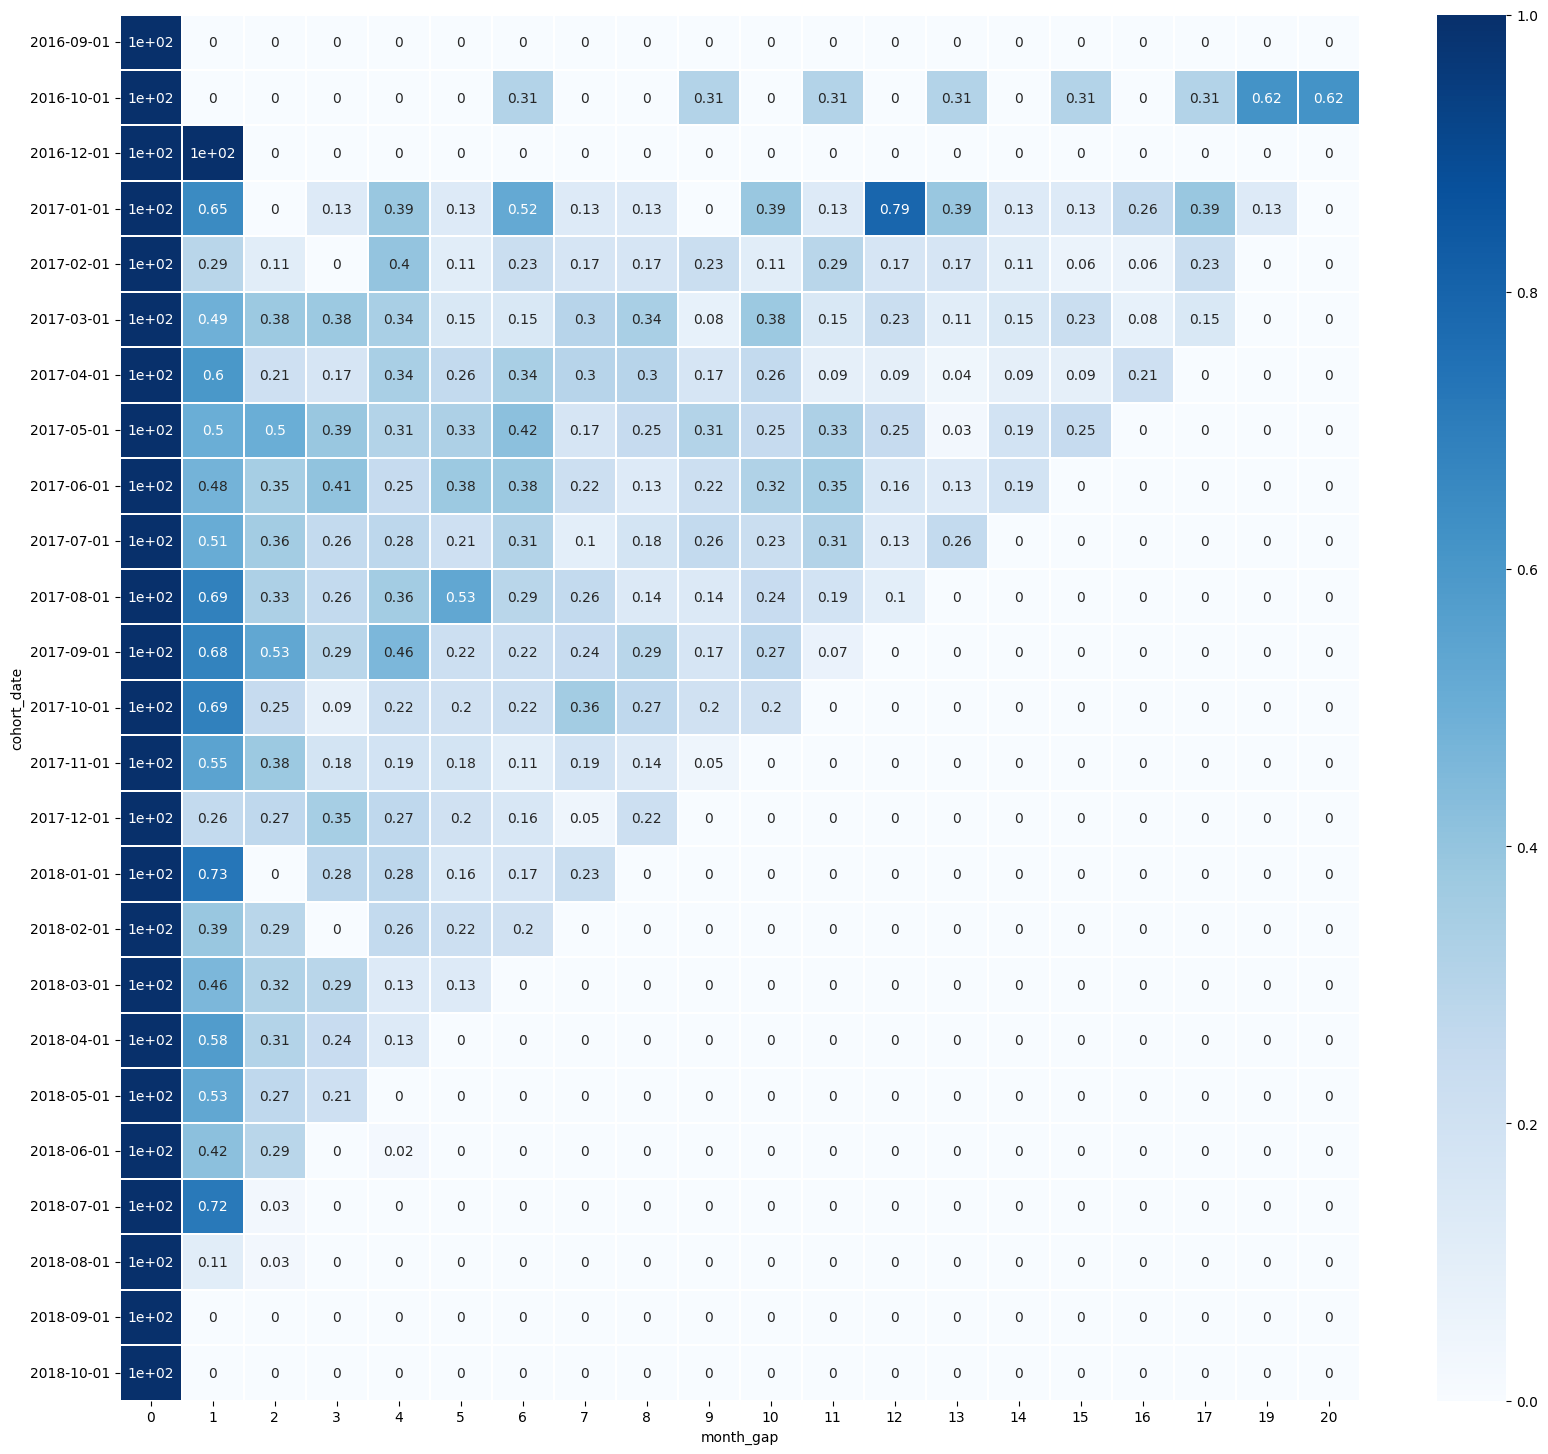

In [280]:
plt.figure(figsize = (20, 18))

sns.heatmap(
        new_df, 
        annot=True, 
        cmap='Blues',
        linewidths=.1,
        vmin = 0, vmax = 1
    )
#plt.show()

#### 2017-01월에 첫 구매한 고객의 11개월 후의 리텐션 0.79로 매우 높은 수치를 보이고 있음

2017-11월의 절대적인 주문 수가 급증한 것은 맞으나, 11개월 후 해당 사이트를 다시 방문하여 제품을 구매한데에는 어떠한 이유가 있을 것이라 판단 
(단순히 블랙프라이데이때문에 방문한 고객들이 아니라 장기간에 걸쳐 해당 사이트를 방문하고 구매까지 이어졌기 때문에 세분화된 분석이 필요하다고 생각됨)

따라서 2017-01에 첫 구매한 고객 코호트의 특징을 전체 코호트와 비교 분석하여, 리텐션이 높은 코호트의 특징을 찾아 리텐션 개선 방안에 힘쓸 것



### 4. 코호트별 특징 분석

1) 가설1: 리텐션 높은 코호트의 review score은 전체 코호트와 상이할 것이다. -> 서비스 또는 제품에 대한 만족도가 높았을 것이다. 


2) 가설2: 리텐션 높은 코호트가 많이 구매한 품목은 전체 코호트와 상이할 것이다. -> 각 코호트를 기반으로 카테고리 별 분석 (특정 상품 카테고리에 만족도가 높았을 것이다.)


3) 가설3: 리텐션 높은 코호트는 전체 고객보다 할인 제품을 더 많이 주문했을 것이다. -> 각 코호트별 할인 여부 

4) 가설4: 리텐션 높은 코호트는 단가가 낮은 물건을 더 많이 주문했을 것이다. -> 각 코호트별 결제 금액 규모

5) 가설5: 리텐션 높은 코호트의 배송이 빨랐을 것이다. 


#### 4- 1 

가설1: 리텐션 높은 코호트의 review score은 전체 코호트와 상이할 것이다. -> 서비스 또는 제품에 대한 만족도가 높았을 것이다.

In [405]:

query12 = """
        with cohort as (
        select customer_unique_id,
        min(strftime('%Y-%m-01', order_purchase_timestamp)) as cohort_date,
        review_score
        from orders o
        left join customers c on o.customer_id = c.customer_id
        left join reviews r on o.order_id = r.order_id
        group by 1 )
        
        select cohort_date, 
        count(distinct customer_unique_id) as count_cohort,
        avg(review_score)
        from cohort
        where cohort_date == '2017-01-01'
        group by 1
        

            """


In [299]:
pd.read_sql_query(query12,conn)


,cohort_date,count_cohort,avg(review_score)
0,2017-01-01,764,4.045093


In [300]:
query13 = """
        with cohort as (
        select customer_unique_id,
        min(strftime('%Y-%m-01', order_purchase_timestamp)) as cohort_date,
        review_score
        from orders o
        left join customers c on o.customer_id = c.customer_id
        left join reviews r on o.order_id = r.order_id
        group by 1 )
        
        select cohort_date, 
        count(distinct customer_unique_id) as count_cohort,
        avg(review_score)
        from cohort
        where cohort_date <> '2017-01-01'
        group by 1
        

            """

In [303]:
query13_df = pd.read_sql_query(query13,conn)
query13_df.describe()

,count_cohort,avg(review_score)
count,24.000000,24.000000
mean,3972.166667,3.743974
std,2577.133117,1.030642
min,1.000000,1.000000
25%,2202.000000,3.881174
50%,4157.000000,4.097917
75%,6316.000000,4.184032
max,7304.000000,5.000000


In [310]:
query14 = """WITH cohort AS (
    SELECT
        customer_unique_id,
        MIN(strftime('%Y-%m-01', order_purchase_timestamp)) AS cohort_date,
        review_score
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
    LEFT JOIN
        reviews r ON o.order_id = r.order_id
    GROUP BY
        1
)

SELECT
    cohort_date,
    CASE WHEN cohort_date = '2017-01-01' THEN 'Retention_Cohort'
         ELSE 'NonRetention_Cohort' END AS cohort_group,
    COUNT(DISTINCT customer_unique_id) AS count_cohort,
    AVG(review_score) AS avg_review_score
FROM
    cohort
GROUP BY
    1"""


In [312]:
query14_df = pd.read_sql_query(query14,conn)

In [314]:
query14_df[query14_df['cohort_group'] == 'NonRetention_Cohort'].describe()

,count_cohort,avg_review_score
count,24.000000,24.000000
mean,3972.166667,3.743974
std,2577.133117,1.030642
min,1.000000,1.000000
25%,2202.000000,3.881174
50%,4157.000000,4.097917
75%,6316.000000,4.184032
max,7304.000000,5.000000


In [315]:
query14_df[query14_df['cohort_group'] == 'Retention_Cohort'].describe()

,count_cohort,avg_review_score
count,1.0,1.000000
mean,764.0,4.045093
std,NaN,NaN
min,764.0,4.045093
25%,764.0,4.045093
50%,764.0,4.045093
75%,764.0,4.045093
max,764.0,4.045093


각 코호트별 리텐션을 확인해보니 '2017-01-01' 코호트의 review_score 평균은 4.045093이며, '2017-01-01'를 제외한 코호트의 review_score 평균은 3.743974 이다. 

'2017-01-01' 코호트의 평균 review_score이 더 높은 것으로 확인되었음 

또한 최솟값을 주목해봐야 할 점이 '2017-01-01' 코호트의 review_score 최솟값은 4.045인 반면 '2017-01-01'를 제외한 코호트의 review_score 최솟값은 1.00이다. 


**전반적인 서비스 또는 제품에 대한 만족도가 훨씬 높았다고 볼 수 있음**

#### 4-2

가설2: 리텐션 높은 코호트가 많이 구매한 품목은 전체 코호트와 상이할 것이다. -> 각 코호트를 기반으로 카테고리 별 분석 (특정 상품 카테고리에 만족도가 높았을 것이다.)

In [476]:
query18= """
   WITH cohort AS (SELECT
        c.customer_unique_id,
        MIN(strftime('%Y-%m-01', order_purchase_timestamp)) AS cohort_date,
        product_category_name_english as cat
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
    INNER JOIN
        items i ON o.order_id = i.order_id
    INNER JOIN
        products p ON i.product_id = p.product_id
    LEFT JOIN 
        translation t ON p.product_category_name = t.product_category_name
    GROUP BY
        1 )
        
    SELECT cat,
    RANK() OVER (ORDER BY COUNT(distinct customer_unique_id) DESC) AS cat_rank
    FROM
        cohort
    WHERE cohort_date == '2017-01-01'
    GROUP BY 
        1

"""

In [477]:
query18_df = pd.read_sql_query(query18,conn)

In [465]:
query19= """
   WITH cohort AS (SELECT
        c.customer_unique_id,
        MIN(strftime('%Y-%m-01', order_purchase_timestamp)) AS cohort_date,
        product_category_name_english as cat
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
    INNER JOIN
        items i ON o.order_id = i.order_id
    INNER JOIN
        products p ON i.product_id = p.product_id
    LEFT JOIN 
        translation t ON p.product_category_name = t.product_category_name
    GROUP BY
        1 )
        
    SELECT cat,
    RANK() OVER (ORDER BY COUNT(distinct customer_unique_id) DESC) AS cat_rank
    FROM
        cohort
    WHERE cohort_date != '2017-01-01'
    GROUP BY 
        1

"""

In [466]:
query19_df = pd.read_sql_query(query19, conn)

In [458]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [455]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [487]:
query20 = """
WITH cohort AS (
    SELECT
        c.customer_unique_id,
        MIN(strftime('%Y-%m-01', order_purchase_timestamp)) AS cohort_date,
        product_category_name_english as cat
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
    INNER JOIN
        items i ON o.order_id = i.order_id
    INNER JOIN
        products p ON i.product_id = p.product_id
    LEFT JOIN 
        translation t ON p.product_category_name = t.product_category_name
    GROUP BY
        1
),

cohort_rank_1 as (SELECT cat,
    RANK() OVER (ORDER BY COUNT(distinct customer_unique_id) DESC) AS cat_rank
FROM
    cohort
WHERE cohort_date == '2017-01-01'
GROUP BY 
    1)


SELECT cohort.cat, cat_rank,
    RANK() OVER (ORDER BY COUNT(distinct customer_unique_id) DESC) AS cat_rank2
FROM
    cohort
inner join cohort_rank_1 a on a.cat = cohort.cat
WHERE cohort_date != '2017-01-01'
GROUP BY 
    1
ORDER BY cat_rank 

"""

In [488]:
pd.read_sql_query(query20,conn)

,cat,cat_rank,cat_rank2
0,furniture_decor,1,5
1,health_beauty,2,2
2,sports_leisure,3,3
3,toys,4,10
4,garden_tools,5,12
5,bed_bath_table,6,1
6,cool_stuff,7,11
7,baby,7,14
8,auto,9,9
9,perfumery,9,13


'2017-01-01' 코호트의 주문 건수의 순위를 cat_rank, '2017-01-01' 이외의 코호트의 주문 건수의 순위를 cat_rank2로 나타냈다. 

순위의 차이가 없는 카테고리는 

- health_beauty	
- sports_leisure
- auto
- small_appliances
- fashion_male_clothing

순위의 차이가 4 이하인 카테고리는 

- agro_industry_and_commerce
- air_conditioning
- computers
- cool_stuff
- dvds_blu_ray
- electronics
- food
- furniture_decor
- market_place
- office_furniture
- perfumery
- pet_shop


순위의 차이가 가장 큰 카테고리는 

- fixed_telephony



결론적으로, '2017-01-01' 코호트의 주문 건수의 순위가 낮고, '2017-01-01' 이외의 코호트의 주문 건수의 순위가 높은 카테고리 항목들의 전반적인 서비스, 품질 만족도가 상대적으로 낮다고 생각할 수 있다

In [500]:
query21 = """
WITH cohort AS (
    SELECT
        c.customer_unique_id,
        MIN(strftime('%Y-%m-01', order_purchase_timestamp)) AS cohort_date,
        product_category_name_english as cat
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
    INNER JOIN
        items i ON o.order_id = i.order_id
    INNER JOIN
        products p ON i.product_id = p.product_id
    LEFT JOIN 
        translation t ON p.product_category_name = t.product_category_name
    GROUP BY
        1
),

cohort_rank_1 as (SELECT cat,
    RANK() OVER (ORDER BY COUNT(distinct customer_unique_id) DESC) AS cat_rank
FROM
    cohort
WHERE cohort_date == '2017-01-01'
GROUP BY 
    1),


cohort_rank_2 as (SELECT cohort.cat, cat_rank,
    RANK() OVER (ORDER BY COUNT(distinct customer_unique_id) DESC) AS cat_rank2
FROM
    cohort
inner join cohort_rank_1 a on a.cat = cohort.cat
WHERE cohort_date != '2017-01-01'
GROUP BY 
    1
ORDER BY cat_rank )

select cat, abs(cat_rank - cat_rank2) as diff
from cohort_rank_2
group by cat 

"""

In [501]:
query21_df = pd.read_sql_query(query21,conn)

In [502]:
query21_df['diff'].describe()

count    41.000000
mean      5.439024
std       3.847394
min       0.000000
25%       3.000000
50%       5.000000
75%       7.000000
max      16.000000
Name: diff, dtype: float64

In [511]:
#query21_df[query21_df['diff'] == 0]
#query21_df[(query21_df['diff'] <= 4 )& (query21_df['diff'] != 0)]['cat']
#query21_df[query21_df['diff'] == 16]

0     agro_industry_and_commerce
1               air_conditioning
6                      computers
10                    cool_stuff
11                  dvds_blu_ray
12                   electronics
19                          food
21               furniture_decor
29                  market_place
31              office_furniture
32                     perfumery
33                      pet_shop
Name: cat, dtype: object

#### 4-3

가설3: 리텐션 높은 코호트는 전체 고객보다 할인 제품을 더 많이 주문했을 것이다. -> 각 코호트별 할인 여부 
payment_value - 주문 당 지불된 총 금액, 결제 금액은 주문의 상품 가격, 배송비, 할인 등을 포함한 총액

In [532]:
query22 = """
WITH cohort AS (
    SELECT
        c.customer_unique_id,
        MIN(strftime('%Y-%m-01', order_purchase_timestamp)) AS cohort_date,
        p.payment_value, i.price
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
    LEFT JOIN
        items i ON o.order_id = i.order_id
    LEFT JOIN
        payments p ON o.order_id = p.order_id

    GROUP BY
        1
)

SELECT 
    cohort_date, 
    payment_value as actual_value,
    price as product_price,
    payment_value - price AS diff
    
FROM 
    cohort



"""

In [534]:
query22_df = pd.read_sql_query(query22,conn)

In [565]:
query22_df.head()

,cohort_date,actual_value,product_price,diff
0,2018-05-01,141.90,129.90,12.00
1,2018-05-01,27.19,18.90,8.29
2,2017-03-01,86.22,69.00,17.22
3,2017-10-01,43.62,25.99,17.63
4,2017-11-01,196.89,180.00,16.89


In [536]:
query22_df[query22_df['cohort_date'] == '2017-01-01']['diff'].mean()

33.442135278514584

In [537]:
query22_df[query22_df['cohort_date'] != '2017-01-01']['diff'].mean()

31.344222628469986

In [541]:
query22_df[query22_df['actual_value'] == query22_df['product_price']]

,cohort_date,actual_value,product_price,diff
838,2018-04-01,99.90,99.90,0.0
1511,2017-08-01,195.00,195.00,0.0
1787,2018-04-01,53.90,53.90,0.0
2168,2018-04-01,99.90,99.90,0.0
2462,2018-05-01,69.90,69.90,0.0
3350,2018-05-01,110.00,110.00,0.0
3573,2018-05-01,99.90,99.90,0.0
3857,2018-05-01,69.90,69.90,0.0
4849,2018-05-01,69.90,69.90,0.0
4908,2018-04-01,109.99,109.99,0.0


In [551]:
query22_df[(query22_df['actual_value'] < query22_df['product_price']) & (query22_df['cohort_date'] != '2017-01-01') &  (query22_df['cohort_date'] != '2017-11-01')]

,cohort_date,actual_value,product_price,diff
19,2018-06-01,8.53,59.90,-51.37
55,2017-12-01,61.33,274.00,-212.67
232,2017-12-01,22.99,49.99,-27.00
254,2018-03-01,2.99,238.00,-235.01
275,2017-10-01,53.13,89.90,-36.77
334,2018-01-01,6.84,340.00,-333.16
366,2018-03-01,20.10,47.90,-27.80
377,2018-03-01,2.84,19.90,-17.06
389,2018-05-01,14.52,91.30,-76.78
423,2018-05-01,16.00,74.99,-58.99


In [559]:
new_f = query22_df[(query22_df['actual_value'] < query22_df['product_price']) & (query22_df['cohort_date'] == '2017-01-01')]

In [573]:
new_f_2 = query22_df[(query22_df['actual_value'] < query22_df['product_price']) & (query22_df['cohort_date'] != '2017-01-01') &  (query22_df['cohort_date'] != '2017-11-01')& (query22_df['cohort_date'] != '2018-11-01')]

In [561]:
#'2017-01-01' 코호트
abs(new_f['diff']).mean()

110.68708333333332

In [574]:
#'2017-01-01' 이외의 코호트
abs(new_f_2['diff']).mean()

97.31652661064426

할인율이 큰 블랙프라이데이를 포함한 2017-11-01 을 제외하고 계산함

'2017-01-01' 코호트와 '2017-01-01' 이외의 코호트의 상품 가격과 실제 지불금의 차이를 구하고, 그 차이의 평균을 구했음

'2017-01-01' 코호트의 차이 평균은 110.68708333333332
'2017-01-01' 이외의 코호트의 차이 평균은 97.31652661064426

#### 4- 4 

가설4: 리텐션 높은 코호트의 배송이 빨랐을 것이다. 


In [374]:
orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [375]:
#delivered

query17 = """WITH cohort AS (
    SELECT
        customer_unique_id,
        MIN(strftime('%Y-%m', order_purchase_timestamp)) AS cohort_date,
        strftime('%Y-%m-%d', order_delivered_customer_date) as deliver_date,
        strftime('%Y-%m-%d', order_estimated_delivery_date) as estimated_date, 
        order_status
    FROM
        orders o
    LEFT JOIN
        customers c ON o.customer_id = c.customer_id
    LEFT JOIN
        reviews r ON o.order_id = r.order_id
    WHERE order_status == 'delivered'
    GROUP BY
        1
    ORDER BY 
        2
)
    select customer_unique_id, 
    cohort_date, 
    case when 
    estimated_date < deliver_date then 'late'
    else 'not late'
    end as delivery_late
    from cohort 
    

"""

In [376]:
query17_df = pd.read_sql_query(query17,conn)

In [377]:
query17_df[query17_df['cohort_date'] == '2017-01']['delivery_late'].value_counts(normalize=True)

delivery_late
not late    0.969317
late        0.030683
Name: proportion, dtype: float64

In [378]:
query17_df[query17_df['cohort_date'] != '2017-01']['delivery_late'].value_counts(normalize=True)

delivery_late
not late    0.931521
late        0.068479
Name: proportion, dtype: float64

#### 리셉션 차트를 통해 유용한 인사이트를 얻으려면 차트를 통해 다음 질문의 답을 찾아봐야 한다. 기본적으로 리텐션은 시간에 따른 변화 추이를 민감하게 살펴봐야 하는 지표이다. 

1) 하나의 코호트 안에서 기간에 따른 유지율을 봤을 때 그 추이가 어떠한가? 유지율이 급격하게 떨어지지 않고, 안정화되는 지점이 있는가? 대략 어느 정도 기간이 지나야 안정화된다고 볼 수 있는가

2) 서로 다른 코호트의 동일한 기간의 유지율을 비교하면 어떠한가 2020년 1월 가입자와 2020년 5월 가입자의 60일 리텐션에 차이가 있는가? 

3) 기간에 따라 나눈 코호트의 규모는 어떻게 달라지고 있는가? 가입자가 꾸준히 증가하는 추세인가 그렇지 않다면 유지되거나 감소하는 추세인가

#### 리텐션 개선하기 

1) 초기에 리텐션 떨어지는 속도 낮추기 

- 활성화 단계에서 이탈이 많은 경로가 어디인지 살펴보면 도움이 됨

2) 리텐션이 안정화된 후에는 기울기를 평평하게 유지해서 오래 유지되게 하기

- 정기적인 커뮤니케이션 플랜, crm 마케팅 활동, 프로모션 등 

